## Import Packages

In [40]:
import os
import calendar
from pathlib import Path # to interact with file system.
import numpy as np # for working with arrays.
import networkx as nx
import pandas as pd # for working with data frames (tables).
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns # Making statistical graphs on top of what matplot can do 
from sklearn import preprocessing
import matplotlib.pylab as plt # %matplotlib inline renders the figure in a notebook
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates

import dmba


%matplotlib inline
!pip install seaborn --upgrade

## Read sales data 

In [25]:
champo_df = pd.read_excel('champo carpet.xlsx', sheet_name='Data Order ONLY')
champo_df.head()

,CustomerCode,CountryName,QtyRequired,TotalArea,Amount,ITEM_NAME,QualityName,DesignName,ColorName,ShapeName,AreaFt,AreaMtr
0,H-1,USA,6,128.25,769.5,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],GREEN/IVORY,REC,128.25,11.543
1,H-1,USA,6,117.00,702.0,HAND TUFTED,TUFTED 60C,DUDLEY [9012],BEIGE,REC,117.00,10.530
2,H-1,USA,7,88.00,616.0,HAND TUFTED,TUFTED 60C,WEMBLY [CC-206],BEIGE/SAGE,REC,88.00,7.920
3,H-1,USA,7,88.00,616.0,HAND TUFTED,TUFTED 60C,SYMPHONY [8900],CHARCOAL,REC,88.00,7.920
4,H-1,USA,5,117.00,585.0,HAND TUFTED,TUFTED 60C,DUDLEY [9012],NAVY/BEIGE,REC,117.00,10.530


## Visualisation

<Figure size 1200x600 with 0 Axes>

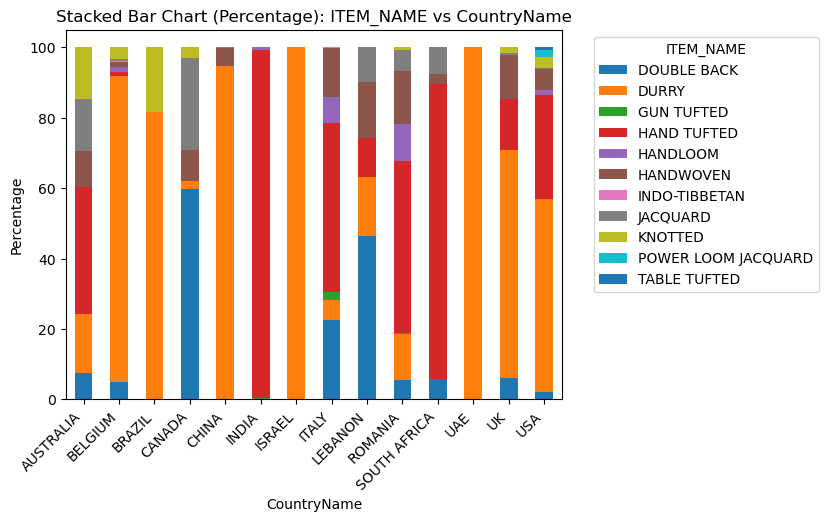

In [26]:
# Filter out rows where 'ITEM_NAME' contains '-'
champo_df_filtered = champo_df[champo_df['ITEM_NAME'] != '-']

#Specify x and y variables
x_variable = 'CountryName'
y_variable = 'ITEM_NAME'

# Create a pivot table for the stacked bar chart
pivot_data = champo_df_filtered.pivot_table(index=x_variable, columns=y_variable, values='QtyRequired', aggfunc='sum', fill_value=0)

# Normalize the values to percentages
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plotting a stacked bar chart with default colors
plt.figure(figsize=(12, 6))
pivot_data_percentage.plot(kind='bar', stacked=True)
plt.title(f'Stacked Bar Chart (Percentage): {y_variable} vs {x_variable}')
plt.xlabel(x_variable)
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title=y_variable, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

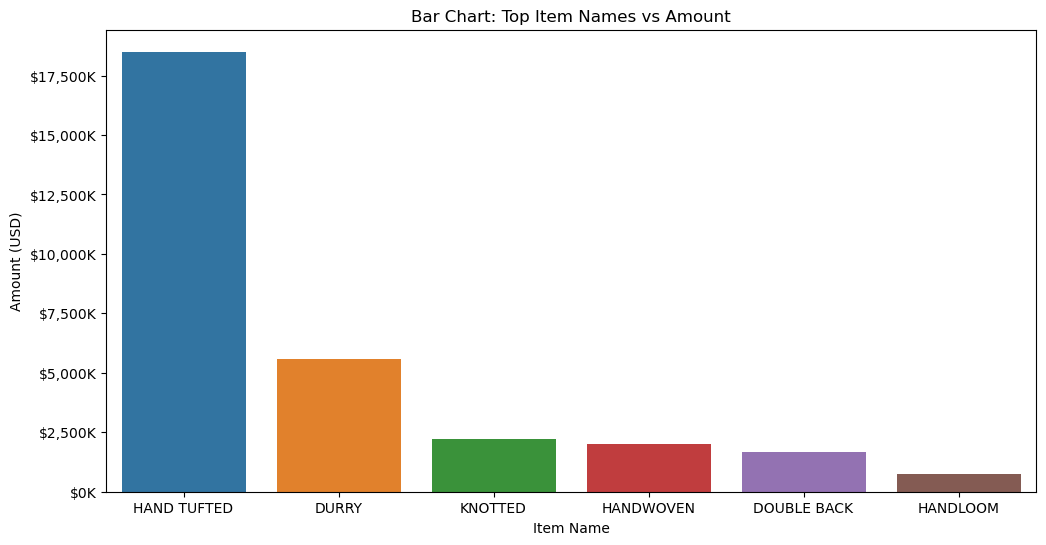

In [27]:
# Group by ITEM_NAME and calculate the total amount for each item
item_amounts = champo_df.groupby('ITEM_NAME')['Amount'].sum().reset_index()

# Sort the data by Amount in descending order for better visualization
item_amounts = item_amounts.sort_values(by='Amount', ascending=False)

# Select the top N items (in this case, top 3)
top_n_items = item_amounts.head(6)

# Plotting a bar chart with formatted y-axis ticks
plt.figure(figsize=(12, 6))
sns.barplot(x='ITEM_NAME', y='Amount', data=top_n_items)

# Format y-axis ticks as currency in USD with thousands (K) notation
formatter = FuncFormatter(lambda x, _: '${:,.0f}K'.format(x/1000))
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Bar Chart: Top Item Names vs Amount')
plt.xlabel('Item Name')
plt.ylabel('Amount (USD)')
plt.show()

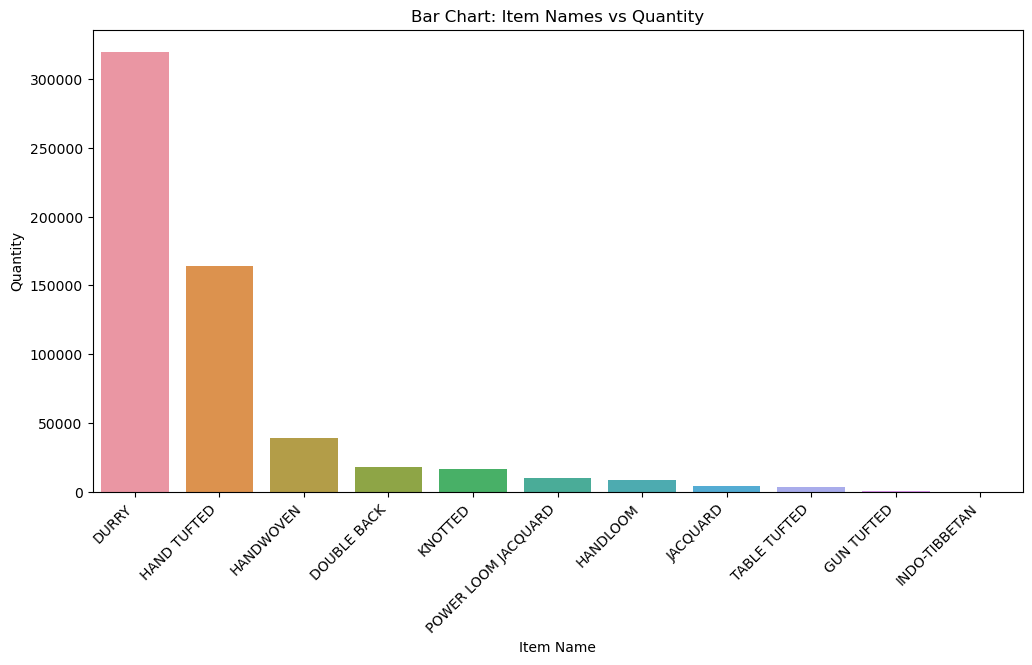

In [28]:
# Filter out rows where 'ITEM_NAME' contains '-'
champo_df_filtered = champo_df[champo_df['ITEM_NAME'] != '-']

# Group by ITEM_NAME and calculate the total quantity for each item
item_quantities = champo_df_filtered.groupby('ITEM_NAME')['QtyRequired'].sum().reset_index()

# Sort the data by Quantity in descending order for better visualization
item_quantities = item_quantities.sort_values(by='QtyRequired', ascending=False)

# Plotting a bar chart with default color
plt.figure(figsize=(12, 6))
sns.barplot(x='ITEM_NAME', y='QtyRequired', data=item_quantities)

plt.title('Bar Chart: Item Names vs Quantity')
plt.xlabel('Item Name')
plt.ylabel('Quantity')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

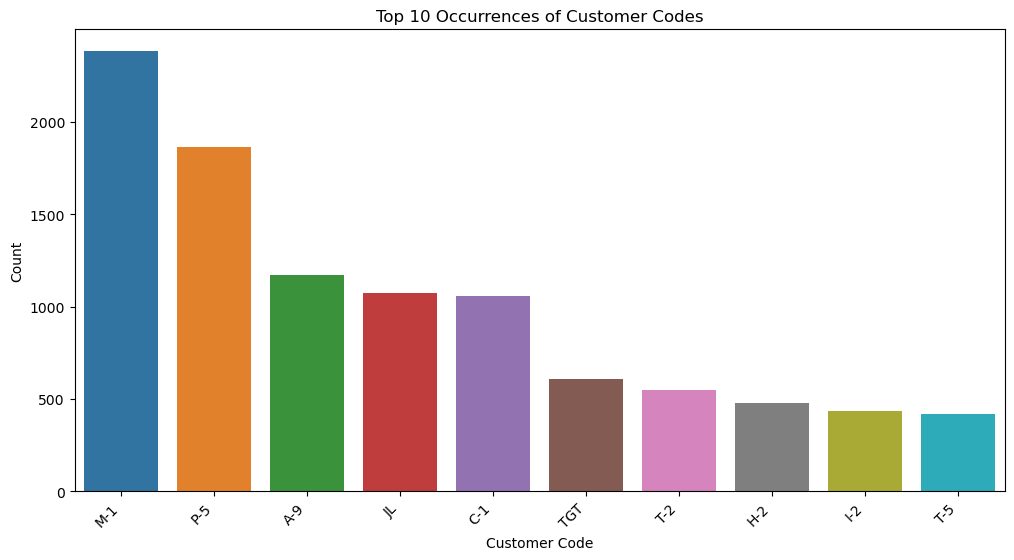

In [34]:
customer_code_counts = champo_df['CustomerCode'].value_counts()

# Select the top 10 occurrences
top_10_counts = customer_code_counts.head(10)

# Plotting with the default color
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_counts.index, y=top_10_counts.values)
plt.title('Top 10 Occurrences of Customer Codes')
plt.xlabel('Customer Code')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


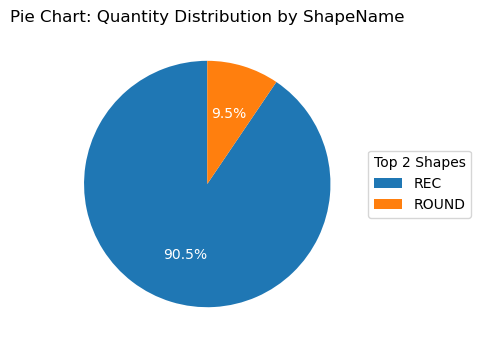

In [44]:
# Extract relevant columns from the DataFrame
shape_qty_data = champo_df.groupby('ShapeName')['QtyRequired'].sum().reset_index()

# Sort the shapes by total quantity in descending order
sorted_shapes = shape_qty_data.sort_values(by='QtyRequired', ascending=False)['ShapeName']

# Select the top two shapes
major_shape_names = sorted_shapes[:2]

# Filter the data for the top two ShapeNames
filtered_data = shape_qty_data[shape_qty_data['ShapeName'].isin(major_shape_names)]

# Plotting a pie chart for ShapeName vs QtyRequired with legend
plt.figure(figsize=(4, 4))
wedges, texts, autotexts = plt.pie(filtered_data['QtyRequired'], labels=filtered_data['ShapeName'],
                                    autopct='%1.1f%%', startangle=90, textprops=dict(color="w"))

# Adding legend with only two major shape names
plt.legend(major_shape_names, title='Top 2 Shapes', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Pie Chart: Quantity Distribution by ShapeName')
plt.show()

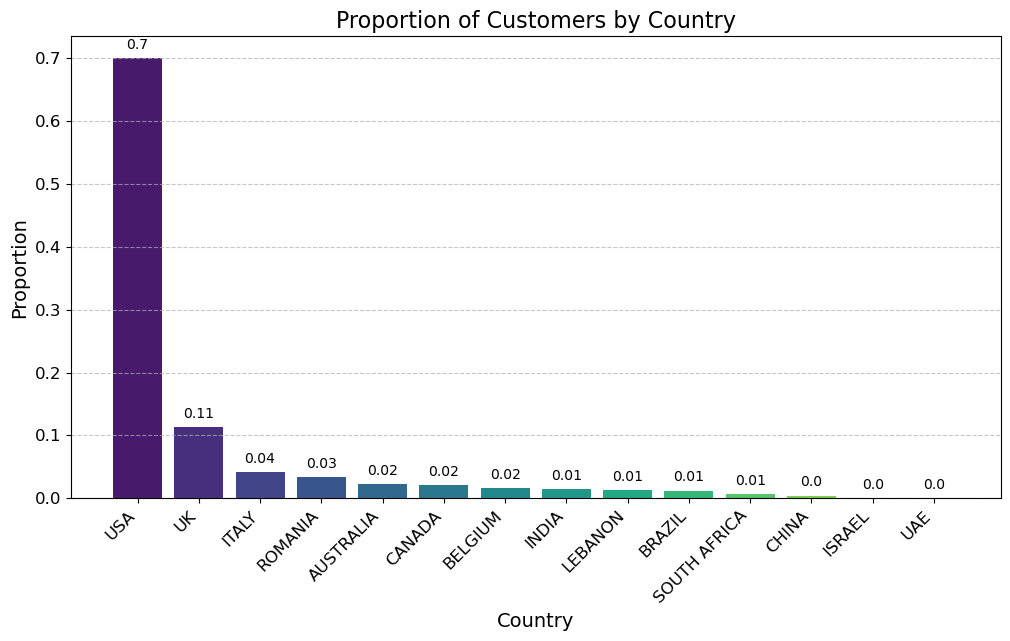

In [31]:

# Calculate the proportion of customers by country
country_proportions = champo_df['CountryName'].value_counts(normalize=True)

# Use a color palette from seaborn for better aesthetics
colors = sns.color_palette("viridis", len(country_proportions))

# Plotting with enhancements
plt.figure(figsize=(12, 6))
bars = plt.bar(country_proportions.index, country_proportions.values, color=colors)
plt.title('Proportion of Customers by Country', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Adding annotations and data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## CLUSTERING 

In [32]:
#Load the customer data
customer_df =  pd.read_excel('champo carpet.xlsx', sheet_name='Data for Clustering')
customer_df.columns
customer_df.set_index('Row Labels', inplace=True)

In [33]:
customer_df_Norm = (customer_df - customer_df.mean()) / customer_df.std()

/var/folders/kz/g6y385js61q82yl1v21tdmbh0000gn/T/ipykernel_50887/3482163349.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(d_norm, method='centroid')


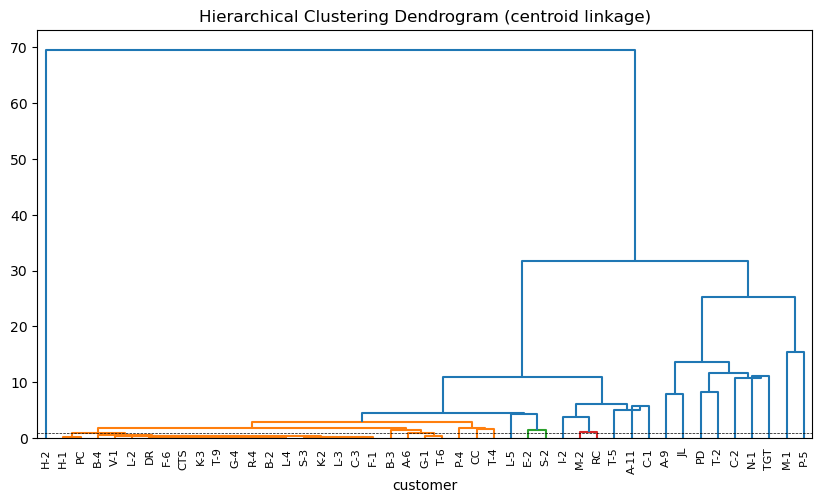

In [10]:
#Method 1 
#metric='euclidean', method='centroid'

d_norm = pairwise.pairwise_distances(customer_df_Norm, metric='euclidean')
pd.DataFrame(d_norm, columns=customer_df_Norm.index, index=customer_df_Norm.index).head(5)

Z = linkage(d_norm, method='centroid') 
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (centroid linkage)')
plt.xlabel('customer')

dendrogram(Z, labels=customer_df_Norm.index, color_threshold=3)
plt.axhline(y=1, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

/var/folders/kz/g6y385js61q82yl1v21tdmbh0000gn/T/ipykernel_50887/1353649692.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(d_norm, method='centroid')


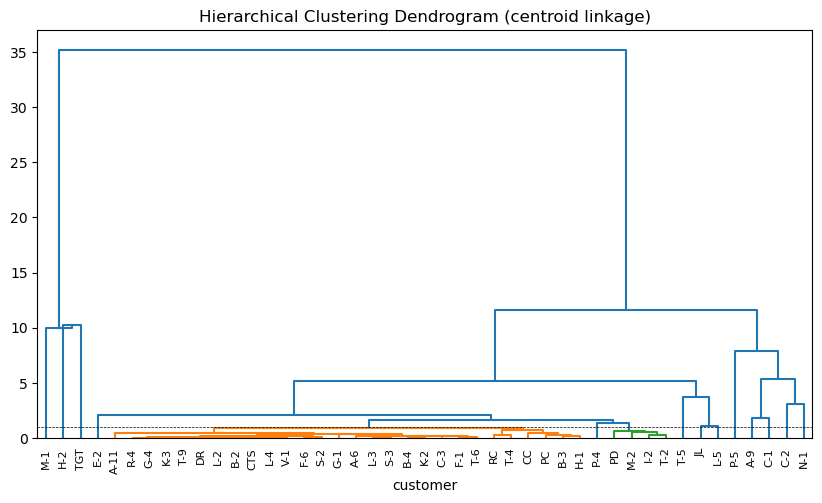

In [11]:
#Method 2
#metric='euclidean', method='centroid'

d_norm = pairwise.pairwise_distances(customer_df_Norm[['Sum of QtyRequired', 'Sum of TotalArea', 'Sum of Amount']], metric='euclidean')
pd.DataFrame(d_norm, columns=customer_df_Norm.index, index=customer_df_Norm.index).head(5)

Z = linkage(d_norm, method='centroid') 
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (centroid linkage)')
plt.xlabel('customer')

dendrogram(Z, labels=customer_df_Norm.index, color_threshold=1)
plt.axhline(y=1, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

/var/folders/kz/g6y385js61q82yl1v21tdmbh0000gn/T/ipykernel_50887/899209000.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(d_norm, method='centroid')


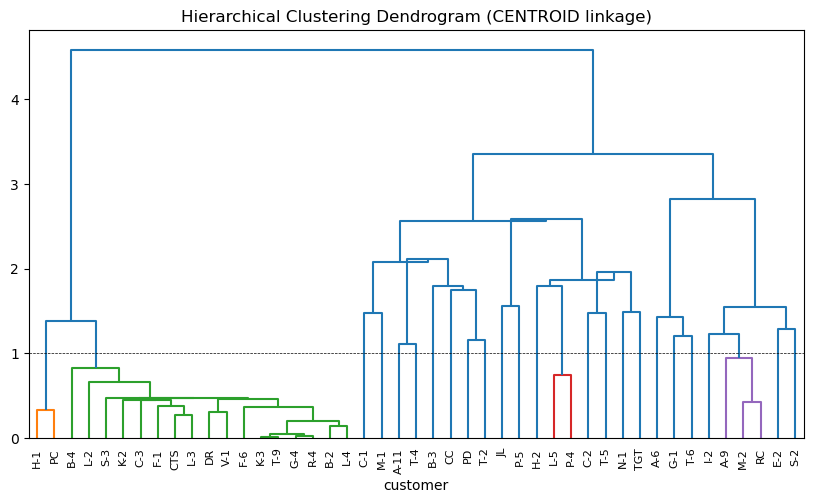

In [12]:
#Method 3
#metric='CORRELATION', method='centroid'

d_norm = pairwise.pairwise_distances(customer_df_Norm, metric='correlation')
pd.DataFrame(d_norm, columns=customer_df_Norm.index, index=customer_df_Norm.index).head(5)

Z = linkage(d_norm, method='centroid') 
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (Centroid linkage)')
plt.xlabel('customer')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z, labels=customer_df_Norm.index, color_threshold=1)
plt.axhline(y=1, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

/var/folders/kz/g6y385js61q82yl1v21tdmbh0000gn/T/ipykernel_50887/3840957199.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(d_norm, method='complete')


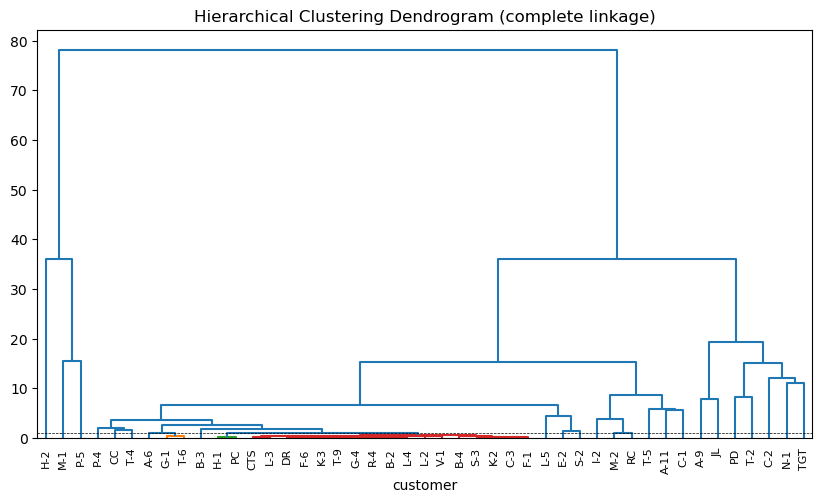

In [45]:
#Method 4
#metric='euclidean', method='complete'

d_norm = pairwise.pairwise_distances(customer_df_Norm, metric='euclidean')
pd.DataFrame(d_norm, columns=customer_df_Norm.index, index=customer_df_Norm.index).head(5)

Z = linkage(d_norm, method='complete') 
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (complete linkage)')
plt.xlabel('customer')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z, labels=customer_df_Norm.index, color_threshold=1)
plt.axhline(y=1, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

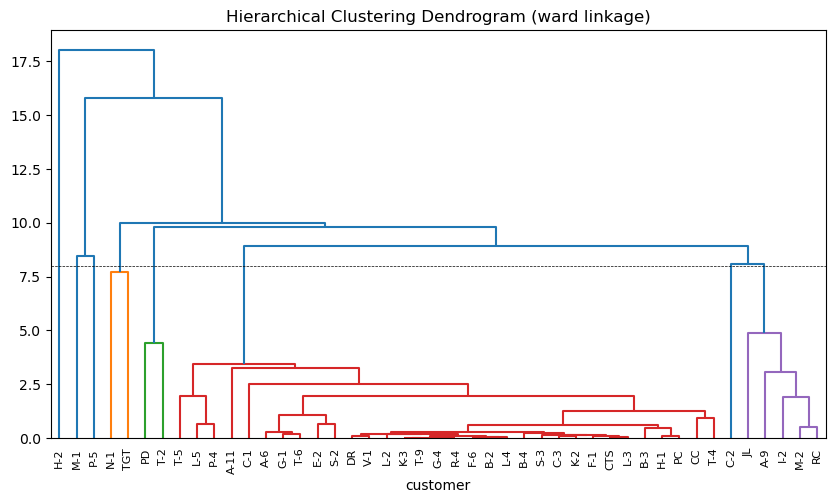

In [46]:
#Final model
#method = ward

Z = linkage(customer_df_Norm, method='ward') 
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (ward linkage)')
plt.xlabel('customer')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z, labels=customer_df_Norm.index, color_threshold=8)
plt.axhline(y=8, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [16]:
memb = fcluster(Z, 6, criterion='maxclust') #no more than 6 clusters
#The above variable has membership of each row. To make it presentable we reorganize next
memb = pd.Series(memb, index=(customer_df_Norm.index))
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

1 :  M-1, P-5
2 :  N-1, TGT
3 :  PD, T-2
4 :  A-11, A-6, B-2, B-3, B-4, C-1, C-3, CC, CTS, DR, E-2, F-1, F-6, G-1, G-4, H-1, K-2, K-3, L-2, L-3, L-4, L-5, P-4, PC, R-4, S-2, S-3, T-4, T-5, T-6, T-9, V-1
5 :  A-9, C-2, I-2, JL, M-2, RC
6 :  H-2


In [19]:
#Add the membership number, that is, the cluster number to the index
customer_df_Norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, customer_df_Norm.index)]


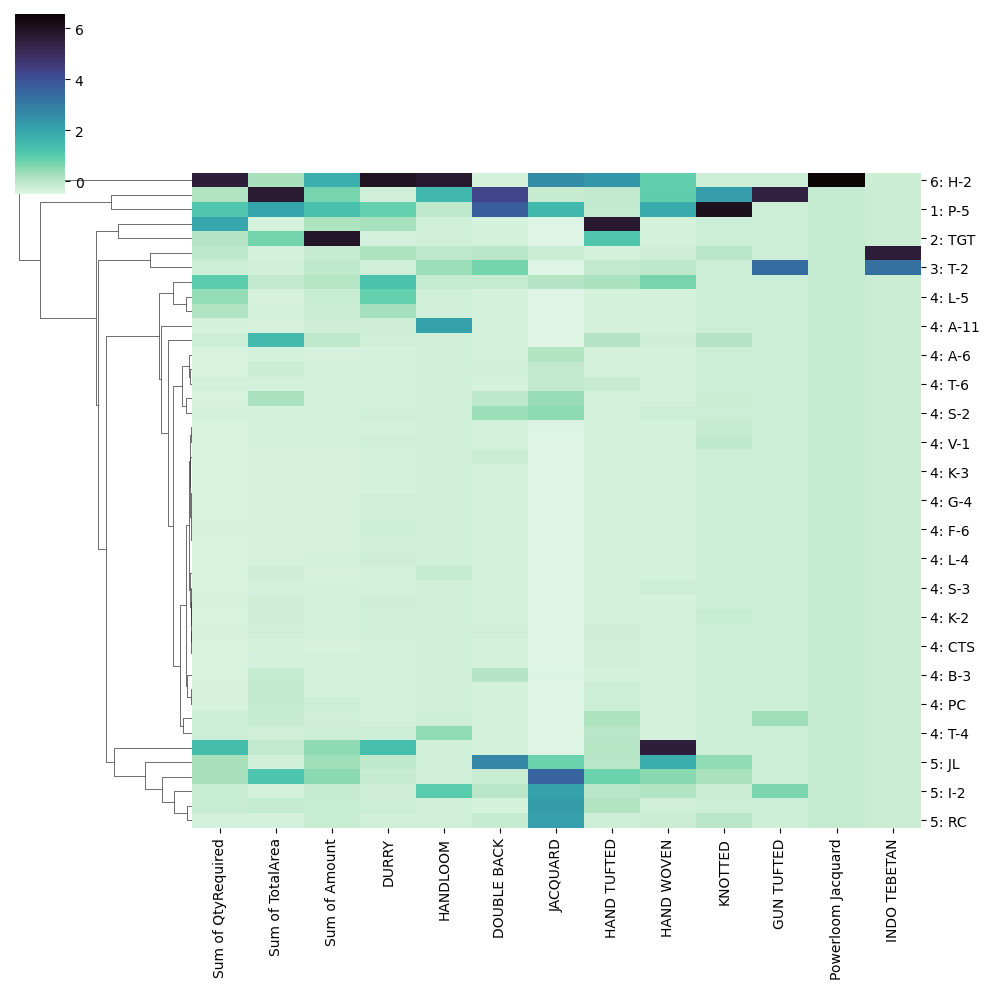

In [20]:
#Cluster map (aka Heat map)
sns.clustermap(customer_df_Norm, method='ward', col_cluster=False,  cmap="mako_r") #mako_r is a commonly used color palette for Heatmaps. 'rocket' is another common one
plt.show()

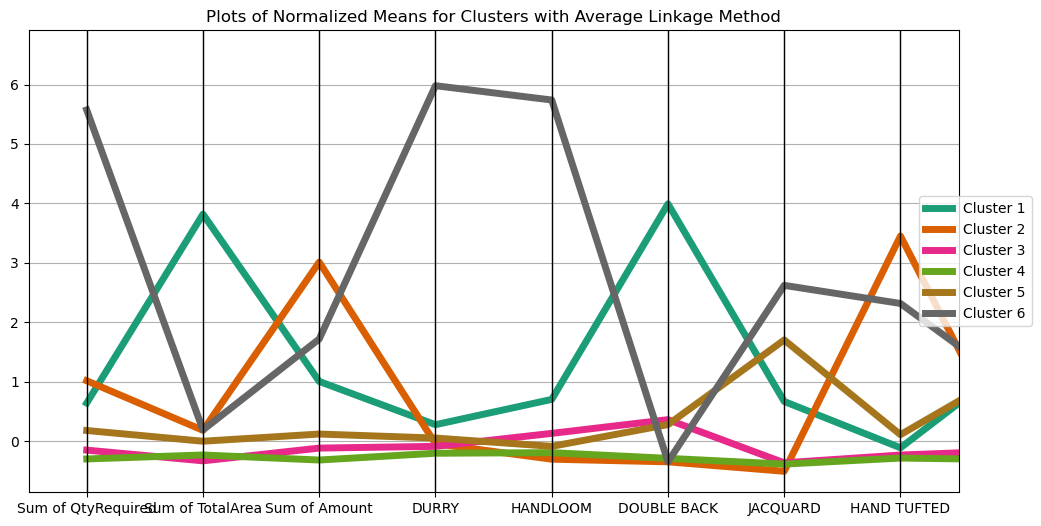

In [22]:
# Create data frame with means of each normalized input variable (measurement) for each cluster 
customer_df_Norm.index = customer_df.index
clust_mean_norm = customer_df_Norm.groupby(memb).mean()
# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals. 
clust_mean_norm['Cluster'] = ['Cluster {}'.format(i) for i in clust_mean_norm.index]
pd.set_option('display.precision', 3)

# Display the data frame with normalized mean values and cluster titles.
clust_mean_norm

# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(12,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(clust_mean_norm, class_column='Cluster', 
                          colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
plt.title('Plots of Normalized Means for Clusters with Average Linkage Method')
plt.show()